# Motion Tracker

Let's see how this goes.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
import os
from PIL import Image
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from model import MotionDataset, PositionFinder, BoundingBoxFinder
import helper

# minmax, minmax_z = helper.get_minmax('train/input.csv', 'test/input.csv')
# print(minmax[0], minmax[1])
# print(minmax_z[0], minmax_z[1])

minmax, minmax_z = helper.get_minmax('train/input.csv', 'test/input.csv')
print(minmax[0], minmax[1])
# print(minmax_z[0], minmax_z[1])

img_width = 256
#randomly rotate or transform the images to help training
train_transforms = transforms.Compose([
#                                         transforms.RandomRotation(30),
#                                         transforms.RandomResizedCrop(256),
                                        transforms.Resize((img_width,img_width)),
                                       transforms.ToTensor()
                                       ,transforms.Normalize([0.485, 0.456, 0.406], 
                                                             [0.229, 0.224, 0.225])
                                      ])

test_transforms = transforms.Compose([
                                       transforms.Resize((img_width,img_width)),
                                       transforms.ToTensor()
                                           ,transforms.Normalize([0.485, 0.456, 0.406], 
                                                             [0.229, 0.224, 0.225])
                                      ])


motions = MotionDataset('train/input.csv', 'train', train_transforms, minmax, minmax_z)
trainloader = DataLoader(motions, batch_size=8, shuffle=True)
inp, output = next(iter(trainloader))

motions_test = MotionDataset('test/input.csv', 'test', test_transforms, minmax, minmax_z)
testloader = torch.utils.data.DataLoader(motions_test, batch_size=8, shuffle=True)

[[427.2828  159.5063  423.8043  ... 175.3759  512.      512.     ]
 [ 58.89619 200.3518   57.66553 ... 109.6327  199.4424  512.     ]
 [ 56.62703 197.7006   55.75322 ... 109.5486  211.0894  512.     ]
 ...
 [267.1249  273.6018  267.8411  ... 156.7243  319.422   334.2008 ]
 [272.3236  252.0337  272.9275  ... 159.5024  333.1688  382.6782 ]
 [160.876   282.3982  162.0605  ...  78.31488 235.9064  403.2061 ]]
0.0 512.0


## Prepare neural network model


In [2]:
device = 'cuda'
model = PositionFinder(img_width)
print(model)

# Boundaries detection
bmodel = BoundingBoxFinder(img_width)
bmodel.load_state_dict(torch.load('bmodel.m'))
train_transforms = transforms.Compose([
                                       transforms.ToTensor()
                                       ,transforms.Normalize([0.485, 0.456, 0.406], 
                                                             [0.229, 0.224, 0.225])
                                      ])

motions = MotionDataset('train/input.csv', 'train', train_transforms, minmax, minmax_z)
trainloader = DataLoader(motions, batch_size=8, shuffle=False)

bboxes = []
bmodel.to(device)

PositionFinder(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_s): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_s): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3_1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_s): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv4_1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_s): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv5_1): Conv

BoundingBoxFinder(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_s): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_s): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3_1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_s): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv4_1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_s): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv5_1): C

tensor([0.0000, 0.3975, 0.3096, 0.8864])
tensor([0.0000, 0.3975, 0.3096, 0.8864])


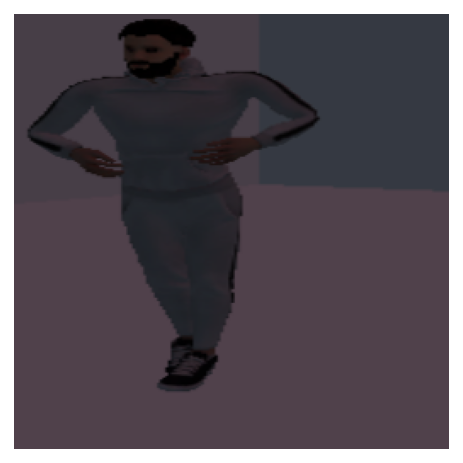

In [3]:
from model import MotionDataset, my_loss
train_transforms = transforms.Compose([
#                                         transforms.RandomRotation(30),
                                       transforms.Resize((img_width,img_width)),
                                       transforms.ToTensor()
                                       ,transforms.Normalize([0.485, 0.456, 0.406], 
                                                             [0.229, 0.224, 0.225])
                                      ])
motions = MotionDataset('train/input_new.csv', 'train', train_transforms, minmax, minmax_z, bmodel=bmodel)
trainloader = DataLoader(motions, batch_size=8, shuffle=True)
inp, output = next(iter(trainloader))
print(inp["bboxes"][0])
print(output["boundaries"][0])
helper.imshow(inp["images"][0])

motions_test = MotionDataset('test/input_new.csv', 'test', test_transforms, minmax, minmax_z, bmodel=bmodel)
testloader = torch.utils.data.DataLoader(motions_test, batch_size=8, shuffle=True)

## Train position finder

best loss (L1Loss Sum, 0.003, conv4)
0.001 - 0.003


```
 Epoch 22/25) Training loss: 6.749771996027863, Test loss: 10.508017539978027
(Epoch 23/25) Training loss: 6.6242278638523295, Test loss: 10.340709686279297
(Epoch 24/25) Training loss: 6.520543051754824, Test loss: 10.395054817199707
```

input contains image (human centered) height, isFacingForward

output contains (x,y) coordinates for 22 body parts
 

In [4]:
from torch import optim, nn
# Optimizers require the parameters to optimize and a learning rate
# optimizer = optim.SGD(model.parameters(), lr=0.00000007, momentum=0.7, weight_decay=0.0005)
optimizer = optim.SGD(model.parameters(), lr=0.003)
criterion = nn.L1Loss(reduction='sum')
bceloss = nn.BCEWithLogitsLoss()
print(torch.cuda.get_device_name(0))
train_losses, test_losses = [], []
epochs = 8
print(model)

model.to(device)

for e in range(epochs):
    running_loss = 0
    for inp, output in trainloader:
        for k in inp:
            inp[k] = inp[k].to(device)
        for k in output:
            output[k] = output[k].to(device)
        
        #1. forward pass
        ps = model.forward(inp["images"], inp["details"], inp["bboxes"])
#         print(ps[0],  output["positions"][0])
#       print(np.min(ps.cpu().detach().numpy()), np.min(targets.cpu().detach().numpy()))
#       print(np.max(ps.cpu().detach().numpy()), np.max(targets.cpu().detach().numpy()))

        #2. calculate loss
#         print(ps[0], positions[0])
#         _loss = criterion(ps, output["positions"]) / 8
#         _bceloss = bceloss(confidences, output["confidences"]) / 5
#         loss = _loss + _bceloss
        loss = criterion(ps, output["positions"])
        #0. Clear the gradients, do this because gradients are accumulated
        optimizer.zero_grad()

        #3. run backward propagation
        loss.backward()

        # 4. Take an update step and few the new weights
        optimizer.step()
        running_loss += loss.item()
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for inp, output in testloader:
                for k in inp:
                    inp[k] = inp[k].to(device)
                for k in output:
                    output[k] = output[k].to(device)
                ps  = model.forward(inp["images"], inp["details"], inp["bboxes"])
#                 _loss = criterion(ps, output["positions"]) / 8
#                 _bceloss = bceloss(confidences, output["confidences"]) / 5
#                 test_loss += _loss + _bceloss
                test_loss += criterion(ps, output["positions"])

        
        model.train()
        
        test_loss = test_loss/len(testloader)
        train_loss = running_loss/len(trainloader)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        print(f"(Epoch {e+1}/{epochs}) Training loss: {train_loss}, Test loss: {test_loss}")
        
PATH = 'model.m'
torch.save(model.state_dict(), PATH)

NVIDIA GeForce RTX 3070
PositionFinder(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_s): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_s): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3_1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_s): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv4_1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_s): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(

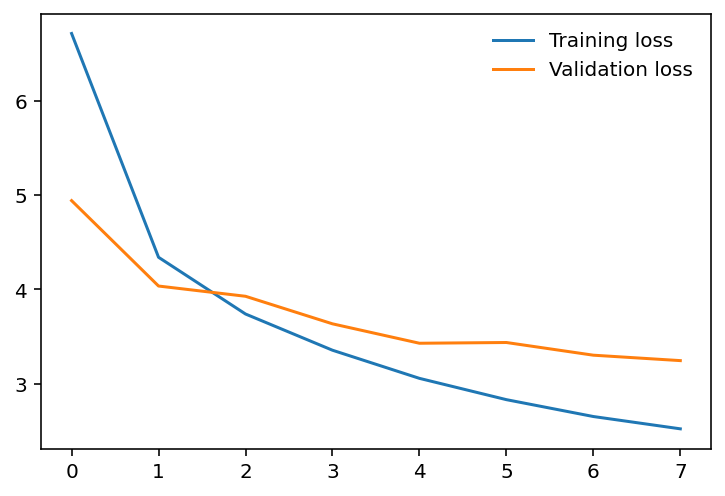

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
test_losses = [test_loss.to('cpu') for test_loss in test_losses]
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

## Use our model

torch.Size([1, 5, 2])


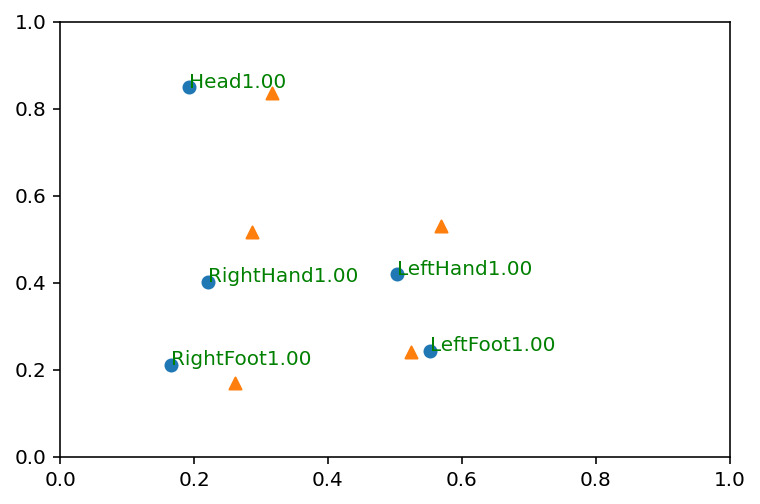

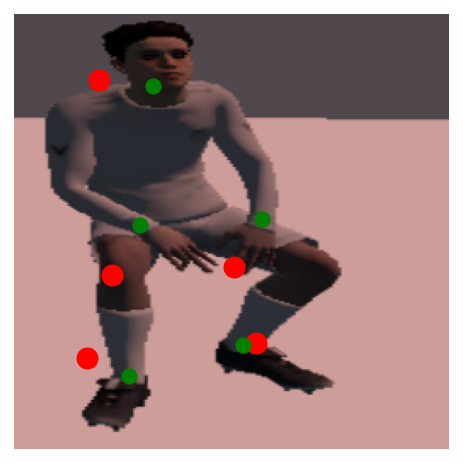

In [20]:
%matplotlib inline
import helper
# motions_test = MotionDataset('train/input.csv', 'train', test_transforms, minmax, minmax_z, bmodel=bmodel)
motions_test = MotionDataset('test/input_new.csv', 'test', test_transforms, minmax, minmax_z, bmodel=bmodel)
testloader = torch.utils.data.DataLoader(motions_test, batch_size=1, shuffle=True)
inp, output = next(iter(testloader))

model = PositionFinder(img_width)
model.load_state_dict(torch.load('model.m'))

# img = images[0].view(1, 195075)
# img = torch.zeros(1,120000) + 222

positions, positions_expected = helper.evaluate_model(model, inp, output)
fig = plt.figure()
ax = plt.axes()

# zdata = positions.T[1]
xdata = positions.T[0]
ydata = positions.T[1]
ax.set_xlim((0,1))
ax.set_ylim((0,1))
ax.scatter(xdata, [1 - y for y in ydata]);

# zdata_e = positions_expected.T[1]
xdata_e = positions_expected.T[0]
ydata_e = positions_expected.T[1]
ax.scatter(xdata_e, [1 - y for y in ydata_e], marker='^')
# helper.imshow(inp["images"][0], xdata=xdata, ydata=ydata)
helper.imshow(inp["images"][0], xdata=xdata, ydata=ydata, xdata_e=xdata_e, ydata_e=ydata_e)

for i, pos in enumerate(positions):
    label = helper.get_label(i)
    if label is not None:
#         label = label + "{:.2f}".format(confidences[0][i].item())
        label = label + "{:.2f}".format(output["confidences"][0][i].item())
        ax.text(pos[0], 1 - pos[1], label, None, color="green")

Total distance 195.11666107177734
Avg distance 39.02333221435547


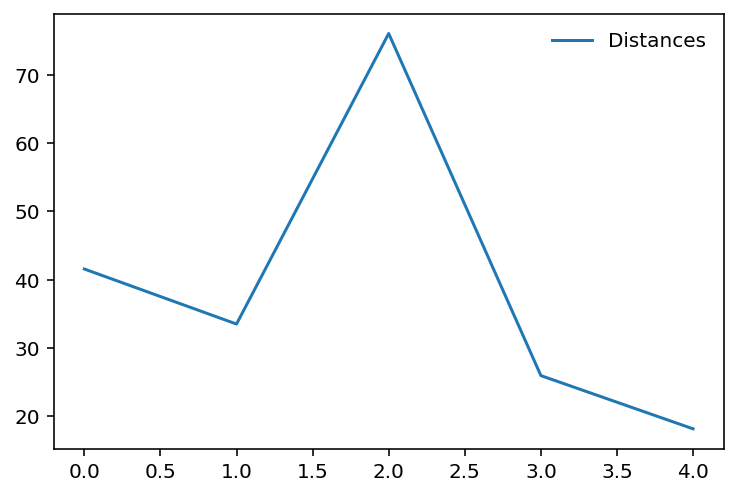

In [7]:
distances = []
for i, pos in enumerate(positions):
    pos_exp = positions_expected[i]
    
    dist = np.linalg.norm(pos_exp-pos)
    distances.append(dist * 512)

print("Total distance", np.array(distances).sum())
print("Avg distance", np.array(distances).mean())
plt.plot(distances, label='Distances')
plt.legend(frameon=False)

## 

torch.Size([1, 5, 2])


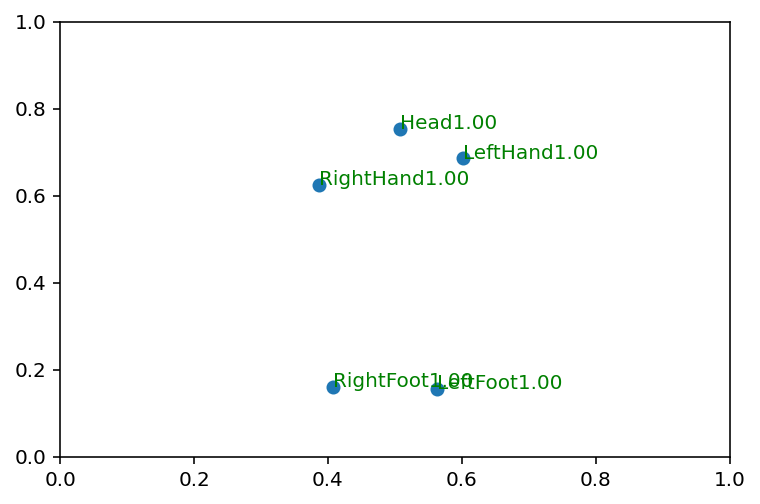

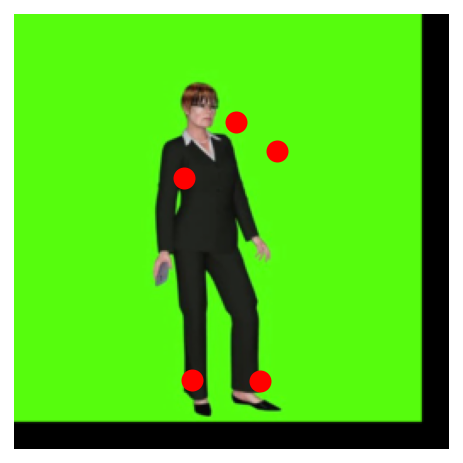

In [24]:
from model import MotionDataset
motions_test2 = MotionDataset('test2/input.csv', 'test2', test_transforms, minmax, minmax_z, bmodel=bmodel)
testloader2 = torch.utils.data.DataLoader(motions_test2, batch_size=1, shuffle=True)
inp, output = next(iter(testloader2))

positions, positions_expected = helper.evaluate_model(model, inp, output)
fig = plt.figure()
ax = plt.axes()

# zdata = positions.T[1]
xdata = positions.T[0]
ydata = positions.T[1]
ax.set_xlim((0,1))
ax.set_ylim((0,1))
ax.scatter(xdata, [1 - y for y in ydata]);

helper.imshow(inp["images"][0], xdata=xdata, ydata=ydata)

for i, pos in enumerate(positions):
    label = helper.get_label(i)
    if label is not None:
#         label = label + "{:.2f}".format(confidences[0][i].item())
        label = label + "{:.2f}".format(output["confidences"][0][i].item())
        ax.text(pos[0], 1 - pos[1], label, None, color="green")